In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`source activate bailfund`

To fetch dockets in backgrounded batches:

```bash
./spawn_batches.sh 42 48 1000 2013
```

http://www.legis.state.pa.us/WU01/LI/LI/CT/htm/18/18.htm

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2777615


In [6]:
import pandas as pd
import re
import os
import subprocess

In [7]:
cd dockets/

[Errno 2] No such file or directory: 'dockets/'
/Users/cchivers/proj/bailfund/dockets


In [12]:
fnames = [f for f in os.listdir('./') if f.endswith('.pdf')]
txt_names = [f for f in os.listdir('./') if f.endswith('.txt')]

f_roots = [f[:-4] for f in fnames]
t_roots = [f[:-4] for f in txt_names]
f_roots = list(set(f_roots) - set(t_roots))
fnames = [f+'.pdf' for f in f_roots]
fnames = [f for f in fnames if os.stat(f).st_size>0]
len(fnames)

3

In [11]:
n_files = len(fnames)
for i,f in enumerate(fnames):
    if (i % int(n_files/10)) == 0:
        print("{0:.0%} complete".format(i/n_files))
    bashCommand = 'pdftotext '+ f
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()

In [8]:
def get_colonic(lines, pre_colonic):
    ao = [l for l in lines if pre_colonic in l]
    key = pre_colonic[:-1]
    if len(ao) == 0:
        return {key:''}
    res = ao[0].split(': ')
    if len(res) > 1:
        res = res[-1].rstrip()
    else:
        res = ''
    return {key: res}

colonics = ['OTN:','Arresting Officer:','Date Filed:','Initiation Date:','Originating Docket No:',
            'Arresting Agency:','Cross Court Docket Nos:','Docket Number:','Nebbia Status:','Printed:']

def get_defendant(lines):
    idx = [i for i,l in enumerate(lines) if 'CASE INFORMATION' in l]
    return {'Defendant': lines[idx[0]-1].rstrip()}
    
def get_all_colonics(lines):
    res = {}
    for colonic in colonics:
        res.update(get_colonic(lines, colonic))
    return res

def get_all_charges(lines):
    all_charges = list(set([re.sub('[ (\n)]','',l) for i,l in enumerate(lines) if ('§' in l)]))
    return {'Charges': all_charges}

def get_bail_amounts(lines):
    idx = [i for i,l in enumerate(lines) if ('BAIL INFORMATION' in l) or ('CHARGES' in l)]
    if len(idx) < 2:
        return {'Bail': []}
    start_idx, end_idx = idx[0], idx[-1]
    amounts = [l.rstrip() for l in lines[start_idx:end_idx] if '$' in l]
    return {'Bail': amounts}

def get_magistrate(lines):
    idx = [i for i,l in enumerate(lines) if ('Arraignment Court Magistrate' in l)]
    res = ''
    if len(idx) > 0:
        res = lines[idx[0]+1].rstrip()
    return {'Arraignment Court Magistrate': res}

def get_arraignment_date(lines):
    prelim = False
    res = {'Arraignment Date': ''}
    for i,l in enumerate(lines):
        if prelim and l.rstrip() == 'Arraignment':
            idx = i
            res = {'Arraignment Date': lines[idx+2].rstrip() + ' ' + lines[idx+4].rstrip()}
            break
        prelim = False
        if l.rstrip() == 'Preliminary':
            prelim = True
    return res

fnames = [f for f in os.listdir('./') if f.endswith('.txt')]
n_files = len(fnames)
res_list = []
print('Extractinng {} dockets'.format(n_files))
for i,fname in enumerate(fnames):
    if (i % int(n_files/10)) == 0:
        print("{0:.0%} complete".format(i/n_files))
    with open(fname,'r') as f:
        lines = f.readlines()
    res = {'fname': fname}
    res.update(get_all_charges(lines))
    res.update(get_all_colonics(lines))
    res.update(get_defendant(lines))
    res.update(get_bail_amounts(lines))
    res.update(get_magistrate(lines))
    res.update(get_arraignment_date(lines))
    res_list.append(res)

res_df = pd.DataFrame(res_list)

Extractinng 238985 dockets
0% complete
10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


,Arraignment Court Magistrate,Arraignment Date,Arresting Agency,Arresting Officer,Bail,Charges,Cross Court Docket Nos,Date Filed,Defendant,Docket Number,Initiation Date,Nebbia Status,OTN,Originating Docket No,Printed,fname
0,Patrick Stack,01/01/2012 12:29 am,Philadelphia Pd,Affiant,[$0.00],"[18§903, 18§3929§§A1]",,01/01/2012,Denia T Brooker,MC-51-CR-0000001-2012,12/31/2011,None,N 781637-3,PARS-MC-51-CR-0000001-2012,06/24/2018,0000001-2012.txt
1,Jane M. Rice,01/01/2013 2:09 am,Philadelphia Pd,"Pollard, Cyrus",[$0.00],[75§3802§§A1*],,01/01/2013,Wesley Deming,MC-51-CR-0000001-2013,12/30/2012,None,N 840695-2,PARS-MC-51-CR-0000001-2013,06/24/2018,0000001-2013.txt
2,,01/01/2014 2:00 am,Philadelphia Pd,"Owens, James F. III","[$250,000.00, $100,000,000.00, $100,000,000.00]","[18§4304§§A1, 18§2701§§B2, 18§6318§§A1, 18§312...","CP-51-CR-0005380-2014, 882 EDA 2016",01/01/2014,ZACHARY MCPHAIL,MC-51-CR-0000001-2014,11/16/2013,None,N 896117-5,1325074777-0000001,06/24/2018,0000001-2014.txt
3,,01/01/2015 3:56 am,Philadelphia Pd,"Lo, T Nong",[$0.00],[18§3929§§A1],CP-51-CR-0001096-2015,01/01/2015,Denise Clayton,MC-51-CR-0000001-2015,12/31/2014,None,N 946101-2,1406058462-0000001,06/23/2018,0000001-2015.txt
4,,01/01/2016 2:35 am,Philadelphia Pd,"Loesch, Daniel","[$150,000.00, $30,000.00, $30,300.00]","[18§6106§§A1, 35§780-113§§A30, 18§907§§A, 18§6...",CP-51-CR-0000616-2016,01/01/2016,Khayrell Keller,MC-51-CR-0000001-2016,12/31/2015,None,N 991937-2,1522116298-0000001,06/23/2018,0000001-2016.txt


In [ ]:
res_df.head()

In [2]:
res_df['Date Filed'] = pd.to_datetime(res_df['Date Filed'])
#res_df['Arraignment Date'] = pd.to_datetime(res_df['Arraignment Date'])
#res_df['Initiation Date'] = pd.to_datetime(res_df['Initiation Date'])
#res_df.shape

In [10]:
res_df['Docket ID'] = res_df['Docket Number'].apply(lambda x: x.split('-')[3])
res_df['Docket Year'] = res_df['Docket Number'].apply(lambda x: x.split('-')[4])

In [11]:
# tmp = res_df[res_df['Docket Year'] == '2016']
# tmp['Docket ID'].astype(int).sort_values().head(10)

0042000 2012
2012-01-01 00:00:00 2012-10-13 00:00:00
0049000 2013
2013-01-01 00:00:00 2013-12-30 00:00:00
0043678 2014
2014-01-01 00:00:00 2015-01-01 00:00:00
0040321 2015
2015-01-01 00:00:00 2016-01-01 00:00:00
0036780 2016
2016-01-01 00:00:00 2017-01-01 00:00:00
0016173 2018
2018-01-01 00:00:00 2018-06-23 00:00:00
0039224 2017
2017-01-01 00:00:00 2017-12-31 00:00:00
0005550 2007
2007-01-26 00:00:00 2007-02-02 00:00:00


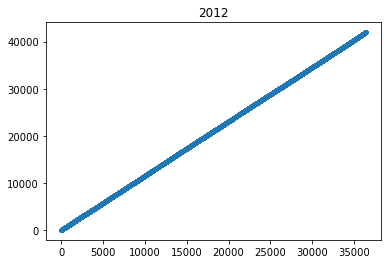

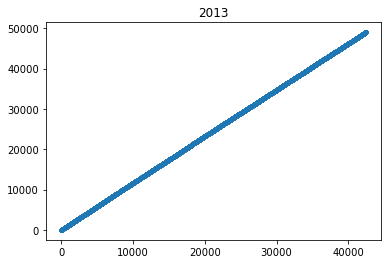

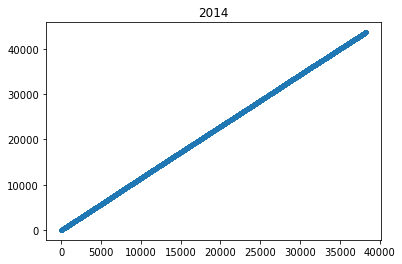

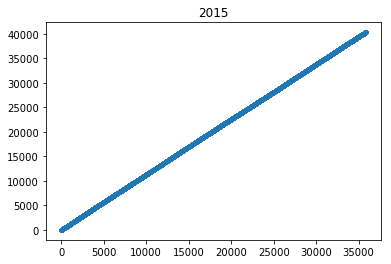

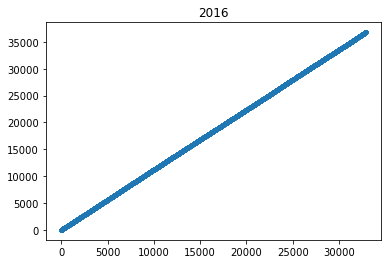

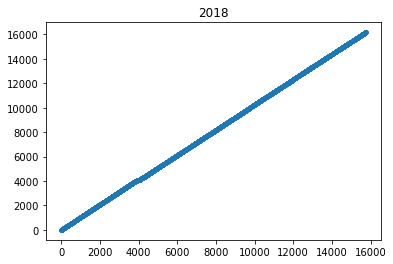

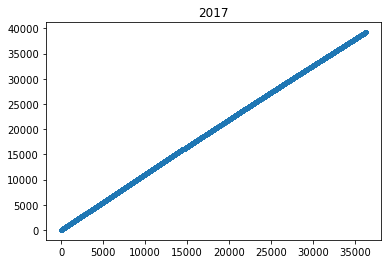

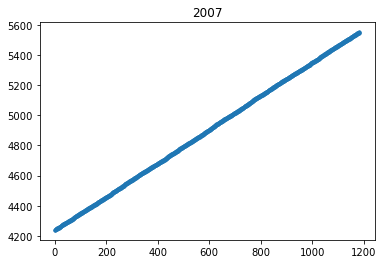

In [12]:
for year in res_df['Docket Year'].unique():
    tmp = res_df[res_df['Docket Year'] == year]
    print(tmp['Docket ID'].max(),year)
    print(tmp['Date Filed'][tmp['Docket ID'].argmin()], tmp['Date Filed'][tmp['Docket ID'].argmax()])
    fig, ax = plt.subplots(1,1)
    ax.plot(tmp['Docket ID'].astype(int).sort_values().values,'.')
    ax.set_title(year)

In [13]:
dockets = res_df.sort_values(['Defendant',
                              'Date Filed']).drop_duplicates(['Defendant',
                                                                    'Date Filed'],keep='last')

In [14]:
dockets.shape

(212818, 18)

In [19]:
dockets['count'] = 1
ts = dockets.set_index('Date Filed').resample('1d').sum().fillna(0)
ts.head()

,count
Date Filed,
2007-01-26,139.0
2007-01-27,151.0
2007-01-28,120.0
2007-01-29,129.0
2007-01-30,111.0


In [20]:
ts.index.min(), ts.index.max(), 

(Timestamp('2007-01-26 00:00:00', freq='D'),
 Timestamp('2018-06-23 00:00:00', freq='D'))

In [21]:
ts['count'].min(), ts['count'].max()

(0.0, 191.0)

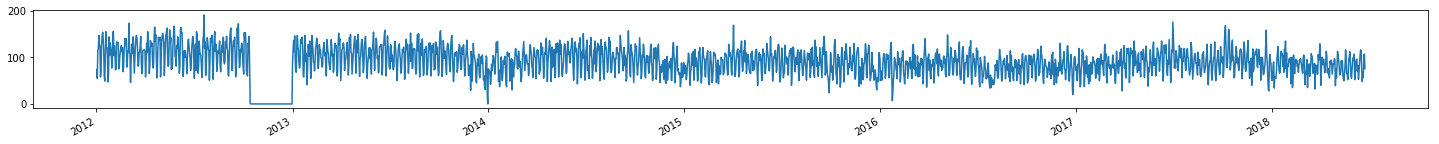

In [22]:
ts = ts[ts.index > datetime.datetime(2012,1,1)]
fig, ax = plt.subplots(1,1,figsize=(25,2))
ax.plot(ts['count'])
fig.autofmt_xdate()

In [17]:
res_df['Arresting Officer'].apply(lambda x: x.upper()).value_counts()

AFFIANT                   605
MCCAULEY, JOSEPH J.       137
CEREBE, KATHALEEN V.      116
WATSON, DUANE A.          102
KILLMAN, ROBERT A.         93
BANNING, PATRICK           87
PROSS, ERIK D.             87
BALMER, JAMES M.           65
SCHWEIZER, SCOTT           62
CESPEDES, BENJAMIN R.      59
RIVERA, RICHARD            48
REILLY, JAMES M.           48
FLYNN, RYAN J.             48
LOMBARDI, MICHAEL A.       43
FITZGERALD, THOMAS         42
ARMSTEAD, TYRIC D.         38
WHITE, KEITH M.            32
OUTTERBRIDGE, BRYAN        29
RIVERA, ERIC               28
LALLY, MATTHEW P.          27
SCHAFFLING, THOMAS A.      27
HARRON, CHARLES M. III     27
ELLIS, JOHN J.             26
LOGAN, GERALD D. III       25
SCOTT, JAMES W. JR.        24
RODRIGUEZ, VICTOR          24
ROBERSTON, MICHAEL         23
HARRIS, STEVEN             23
CURRAN, JAMES J. III       22
FLOYD, MELVIN R.           21
                         ... 
LE, TRANG                   1
PEREZ, TIFFANY              1
POWELL, KE

In [18]:
all_bail = []
first_bail = []
for b in res_df['Bail'].values:
    all_bail.extend(b)
    if len(b)>0:
        first_bail.append(b[0])
pd.Series(all_bail).value_counts()

$0.00                                                                                                        3935
$5,000.00                                                                                                    1678
$2,500.00                                                                                                    1030
$10,000.00                                                                                                    813
$50,000.00                                                                                                    584
$25,000.00                                                                                                    496
$1,000.00                                                                                                     380
$15,000.00                                                                                                    375
$1,500.00                                                                               

In [19]:
import numpy as np

In [20]:
first_bail_series = pd.Series([float(re.sub('[\$,]','',b)) for b in first_bail])
first_bail_series.value_counts()

0.0           3557
5000.0        1025
2500.0         574
10000.0        548
50000.0        385
25000.0        313
1500.0         241
15000.0        240
1000.0         230
100000.0       194
150000.0       168
7500.0         154
20000.0        146
75000.0        144
250000.0       126
3000.0         101
200000.0        79
500000.0        74
6700.0          72
3500.0          71
12000.0         60
3700.0          60
4000.0          47
2000.0          47
500.0           46
35000.0         41
350000.0        37
8000.0          32
300000.0        30
6000.0          27
              ... 
300.0           15
22500.0         11
60000.0         11
125000.0         8
40000.0          8
10000000.0       8
400000.0         8
9000.0           6
1500000.0        5
175000.0         4
18000.0          4
5000000.0        4
450000.0         4
7000.0           3
600000.0         3
900000.0         3
45000.0          2
120000.0         2
12500.0          2
2000000.0        2
6500.0           2
70000.0     

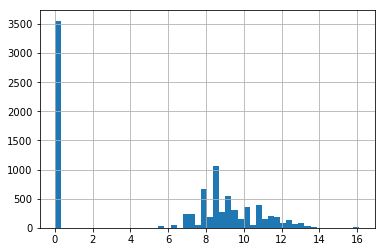

In [21]:
np.log(first_bail_series + 1).hist(bins=50)

In [22]:
first_bail_series.max()

10000000.0

In [23]:
res_df[res_df['Bail'].apply(lambda x: len(x)) > 2]['Bail'].values

array([['$150,000.00', '$30,000.00', '$30,300.00'],
       ['$5,000.00', '$5,000.00', '$7,500.00', '$7,500.00', '$7,500.00', '$15,000.00', '$0.00'],
       ['$0.00', '$2,500.00', '$2,500.00'],
       ['$0.00', '$7,500.00', '$300.00'],
       ['$5,000.00', '$5,000.00', '$5,000.00'],
       ['$50,000.00', '$100,000.00', '$50,000.00'],
       ['$300,000.00', '$200,000.00', '$200,000.00'],
       ['$200,000.00', '$10,000.00', '$10,000.00'],
       ['$1,500.00', '$1,500.00', '$3,000.00'],
       ['$30,000.00', '$30,000.00', '$30,000.00', '$30,000.00', '$50,000.00', '$50,000.00', '$50,000.00', '$150,000.00'],
       ['$2,500.00', '$2,500.00', '$5,000.00'],
       ['$0.00', '$0.00', '$2,500.00'],
       ['$750,000.00', '$200,000.00', '$200,000.00', '$200,000.00'],
       ['$6,700.00', '$6,700.00', '$6,700.00'],
       ['$1,000.00', '$1,000.00', '$1,000.00'],
       ['$1,000.00', '$1,000.00', '$5,000.00'],
       ['$0.00', '$1,000.00', '$2,500.00'],
       ['$3,500.00', '$3,500.00', '$10,000.0